# Tests para nueva función normal

In [17]:
import numpy as np
import matplotlib.pyplot as plt


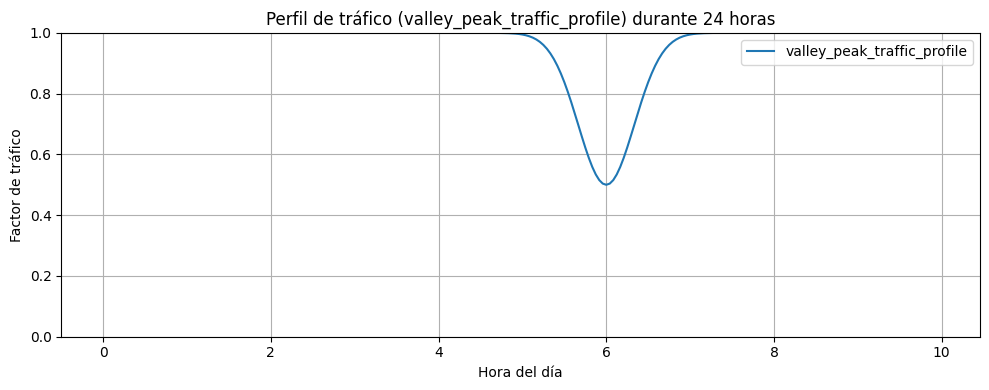

In [18]:
def f_gaussiana_finde(t, _sigma=8*3600, _mu=6*24*3600, _limit=0.5):
    return 1 - _limit * np.exp(-0.5 * ((t - _mu) / _sigma) ** 2)

# Graficar la función valley_peak_traffic_profile para 24 horas (en segundos)
t_segundos_plot = np.arange(0, 10*24*3600, 3600)  # cada minuto
valores = f_gaussiana_finde(t_segundos_plot)

plt.figure(figsize=(10,4))
plt.plot(t_segundos_plot / (3600*24), valores, label="valley_peak_traffic_profile")
plt.xlabel("Hora del día")
plt.ylabel("Factor de tráfico")
plt.ylim(0,1)
plt.title("Perfil de tráfico (valley_peak_traffic_profile) durante 24 horas")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

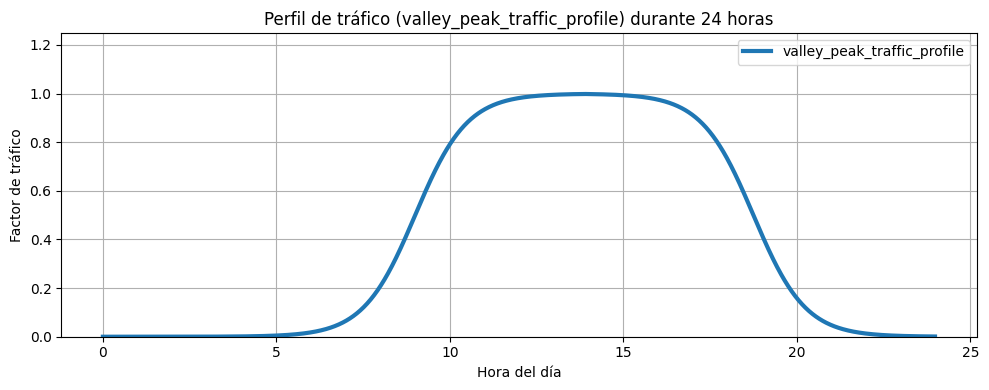

In [24]:
DIA_SEGUNDOS = 24 * 3600

# Parámetros configurables para el pulso de fin de semana
# Día y hora de inicio del pulso (por defecto: día 0, 06:00)
DIA_SUBIDA = 0
HORA_INICIO_SUBIDA = 6
HORA_FIN_SUBIDA = 7.5
HORA_FIN_SUBIDA = 12
# Día y hora de fin del pulso (por defecto: día 5, 12:00)
DIA_BAJADA = 0
HORA_INICIO_BAJADA = 20.5
HORA_INICIO_BAJADA = 16
HORA_FIN_BAJADA = 21.5


# Cálculo de los instantes clave en segundos
_SUBIDA_START = DIA_SUBIDA * 24 * 3600 + HORA_INICIO_SUBIDA * 3600
_SUBIDA_END = DIA_SUBIDA * 24 * 3600 + HORA_FIN_SUBIDA * 3600
_SUBIDA_MID = (_SUBIDA_START + _SUBIDA_END) / 2

_BAJADA_START = DIA_BAJADA * 24 * 3600 + HORA_INICIO_BAJADA * 3600
_BAJADA_END = DIA_BAJADA * 24 * 3600 + HORA_FIN_BAJADA * 3600
_BAJADA_MID = (_BAJADA_START + _BAJADA_END) / 2

def _sigmoid(x, midpoint, width):
    # width controla la "pendiente" de la sigmoide (más pequeño = más abrupto)
    return 1 / (1 + np.exp(-(x - midpoint) / width))

def f_gaussiana_finde_pulso(t_segundos, transition_width=3600*3/4, base=0.6, peak=1.0):
    """
    Perfil de pulso para fin de semana:
    - Entre las 06:00 del día 1 y las 12:00 del día 1 ocurre la subida (sigmoide) de base a peak.
    - Entre las 06:00 del día 6 (sábado) y las 12:00 del día 6 ocurre la bajada (sigmoide) de peak a base.
    Las transiciones son suaves (sigmoides).
    """
    # Recortar t_segundos a la semana y convertir a array para operaciones vectorizadas
    t = t_segundos % DIA_SEGUNDOS
    # t = np.asarray(t_segundos) % DIA_SEGUNDOS

    # Sigmoide de subida: pasa de base a peak
    subida = base + (peak - base) * _sigmoid(t, _SUBIDA_MID, transition_width)
    # Sigmoide de bajada: pasa de peak a base
    bajada = peak - (peak - base) * _sigmoid(t, _BAJADA_MID, transition_width)

    # El perfil es: base fuera del pulso, peak dentro del pulso (subida y bajada suaves)
    # El valor final es el mínimo entre subida y bajada (para formar el "pulso" de fin de semana)
    return np.minimum(subida, bajada)


# Graficar la función valley_peak_traffic_profile para 24 horas (en segundos)
t_segundos_plot = np.arange(0, 24*3600, 60)  # cada minuto
valores = f_gaussiana_finde_pulso(t_segundos_plot, base=0)

plt.figure(figsize=(10,4))
plt.plot(t_segundos_plot / (3600), valores, label="valley_peak_traffic_profile", lw=3)
plt.xlabel("Hora del día")
plt.ylabel("Factor de tráfico")
plt.ylim(0,1.25)
plt.title("Perfil de tráfico (valley_peak_traffic_profile) durante 24 horas")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

In [20]:
def f_gaussiana_base(t, _sigma=4*3600, _mu=12*3600):
    return 1 - np.exp(-((t - _mu)**2) / (2 * _sigma**2))



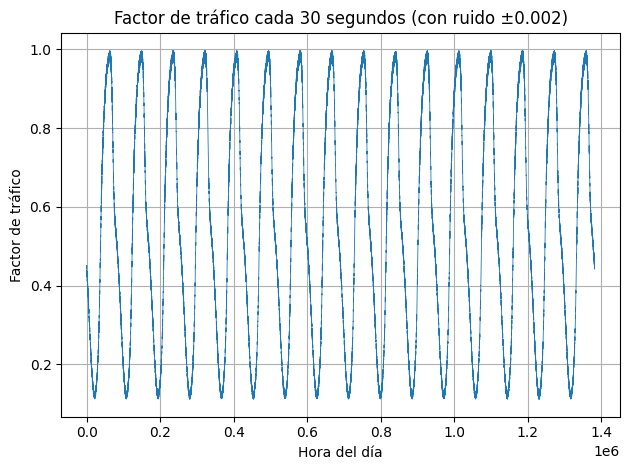

In [21]:

# Función modificada con crecimiento desde 10am y pico en 8pm
def valley_peak_traffic_profile(t_segundos, _alpha=0.2, _offset=0.2):
    """
    Devuelve el perfil de tráfico evaluado para tiempo en segundos.
    """
    # Función normal complementaria
    return _offset + (1 - _offset) * (
            f_gaussiana_base(t_segundos)
    )


def estimate_traffic_from_seconds(t_segundos_orig, ruido=True, ruido_max=0.015, seed=None, weekend_cap=0.5):
    """
    Devuelve el factor de tráfico para un instante temporal dado en segundos.
    Usa interpolación con resolución de 15 minutos (900s) y ruido opcional.
    """
    # Desplazamos el tiempo 6 horas hacia adelante, para ajustar el valle de la función
    t_segundos_des = t_segundos_orig + 6 * 3600

    # Normalizar el tiempo al rango de un día
    t_segundos_norm = t_segundos_des % (24 * 3600)  # segundos en un día

    # Crear vector base de referencia (cada 15 minutos = 900s)
    tiempos_base = np.arange(0, 24 * 3600, 900)
    perfil_base = valley_peak_traffic_profile(tiempos_base)

    # Interpolación
    valor_estimado = np.interp(t_segundos_norm, tiempos_base, perfil_base)

    # Aplicar ruido
    if ruido:
        if seed is not None:
            np.random.seed(seed)
        delta = np.random.uniform(-ruido_max, ruido_max)
        valor_estimado += delta


    # Fin de semana = dias 6 y 7. Obtener el equivalente en dia respecto de los segundos
    t_segundos_semana = (t_segundos_orig - 1 * 3600) % (7 * 24 * 3600)
    valor_estimado = valor_estimado * f_gaussiana_finde_pulso(t_segundos_semana)

    return valor_estimado





# Simular tráfico cada 1 hora durante 2 semanas
t_segundos = np.arange(0, 16*24*3600, 60)
factores = [estimate_traffic_from_seconds(t) for t in t_segundos]

# Graficar
# horas_decimal = t_segundos / 3600
horas_decimal = t_segundos 
plt.plot(horas_decimal, factores, lw=0.6)
plt.title("Factor de tráfico cada 30 segundos (con ruido ±0.002)")
plt.xlabel("Hora del día")
plt.ylabel("Factor de tráfico")
plt.grid(True)
plt.tight_layout()
plt.show()